In [31]:
%matplotlib inline
from __future__ import print_function
import argparse, gzip, cPickle, sys, time, itertools

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
import autograd.scipy.stats.dirichlet as dirichlet
from autograd.scipy.misc import logsumexp
from autograd.util import flatten_func, flatten
from autograd import grad, primitive
from autograd.numpy.numpy_grads import unbroadcast

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import mixture

from  autograd.scipy.special import gammaln, digamma, gamma
from scipy import linalg
from scipy import stats, integrate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import pandas as pd
import six


color_names = ["maroon",               
               "gold",
               "royal blue"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
color_iter = itertools.cycle(colors)

def plot_results(ax, X, Y, means, covariances, index, title):    
    for i, (mean, covar, color) in enumerate(zip(
             means, covariances, color_iter)):
        v, w = linalg.eigh(np.diag(np.full([2], covar)))
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])      

        if not np.any(Y == i):
            continue
        ax.scatter(X[Y == i, 0], X[Y == i, 1], 2., color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        
        
class Adam(object):
    def __init__(self, dparam, b1=0.9, b2=0.999, eps=10**-8,
                         decay_rate = 0.9, decay_steps = 100):                    
        self.b1 = b1;
        self.b2 = b2;
        self.eps = eps        
        self.m = np.zeros(dparam)
        self.v = np.zeros(dparam)
        self.i = 0
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
    
    def update(self, gradients, params, learning_rate = 0.1):        
        self.i = self.i+1
        step_size = learning_rate * self.decay_rate**(self.i/self.decay_steps)        
        self.m = (1 - self.b1) * gradients + self.b1 * self.m
        self.v = (1 - self.b2) * (gradients**2) + self.b2 * self.v
        mhat = self.m / (1 - self.b1**(self.i))
        vhat = self.v / (1 - self.b2**(self.i))                        
        params = params + step_size*mhat/(np.sqrt(vhat) + self.eps)        
        return np.split(params,2)

@primitive
def softplus(x):
    return np.log(1. + np.exp(x))

softplus.defvjp(lambda g, ans, vs, gvs, x: unbroadcast(vs, gvs, g * 1./(1. + np.exp(-x))))

def jacobian_softplus(x):
    return 1./(1. + np.exp(-x))

@primitive
def gamma_logpdf(x, alpha = 1., beta = 1.):
    return  (alpha*np.log(beta) + (alpha - 1)*np.log(x) - x*beta - gammaln(alpha))

gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs, g * ((alpha-1)/x - beta)))
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (np.log(beta) + np.log(x) - digamma(alpha))), argnum=1)
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (alpha/beta - x)), argnum=2)

In [32]:
class Normal(object):
    def __init__(self, data, scale = 1.):
        self.data = data     
        self.scale = scale
        self.N = data.shape[0]
        self.D = data.shape[1]
    
    def p_log_prob(self, idx, z):
        x = self.data[idx]
        mu, tau = z['mu'], softplus(z['tau'])
        log_prior = 0.
        log_prior = np.sum(gamma_logpdf(tau, 1e-3, 1e-3)) + np.sum(np.log(jacobian_softplus(z['tau'])))
        log_prior += np.sum(norm.logpdf(mu, 0., 1/np.sqrt(tau)))        
        log_lik = np.sum(norm.logpdf(x, mu, 1/np.sqrt(tau)))
        return self.scale * log_lik + log_prior
             
    def q_log_prob(self, means, log_sigmas, z):
        q_w = np.sum(norm.logpdf(z, means, np.exp(log_sigmas)))        
        return q_w
      
    def q_log_prob_sep(self, means, log_sigmas, z):
        q_w = norm.logpdf(z, means, np.exp(log_sigmas))        
        return q_w

    def phi_log_prob_sep(self, eps):
        phi_w = norm.logpdf(eps, 0., 1.)        
        return phi_w

    def sample_q(self, means, log_sigmas, d):        
        eps = npr.randn(d)        
        q_s = np.exp(log_sigmas) * eps + means
        return (q_s, eps)
        
    def grad_params(self, dp_log_prob, eps, log_sigmas):                
        grad_means = dp_log_prob
        grad_log_sigmas = dp_log_prob*eps*np.exp(log_sigmas) + 1                
        return np.concatenate([grad_means, grad_log_sigmas])
        
    def calc_eps(self, means, log_sigma, z):        
        eps  = (z - means)/np.exp(log_sigma)
        return eps                

In [33]:
class Inference(object):      
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def run(self, epochs, batch_size, samples, learning_rate, algorithm = 'SGD', optimizer = 'adam'):
        epochs = epochs
        batches = self.model.N/batch_size
        batch_size = batch_size
        samples = samples
        learning_rate = learning_rate        
        
        means, unflatten = flatten(self.params['means'])
        log_sigmas, unflatten = flatten(self.params['log_sigmas'])        
        D =len(means)

        self.F = np.zeros(epochs * batches)
        self.time = np.zeros(epochs * batches)
        adam = Adam(2*D)
        f = 0
        
        grad_p_log_prob = grad(model.p_log_prob, argnum = 1)
        grad_q_log_prob = grad(model.q_log_prob, argnum = 1)
        
        if algorithm == 'SGD':
            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                    
                    d_elbo = 0.

                    for s in range(samples):
                        eps = npr.randn(D)        
                        z = np.exp(log_sigmas) * eps + means                                            
                        p_log_prob = model.p_log_prob(idx, unflatten(z))                        
                        dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                        g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                        d_elbo += g
                        q_log_prob = model.q_log_prob(means, log_sigmas, z)                                         
                        losses +=  (p_log_prob - q_log_prob)                    
                    loss = losses/samples
                    d_elbo /= samples   
                    means_old, log_sigmas_old = means, log_sigmas
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]), learning_rate)
                    if np.sum(np.isnan(means)) > 0 or np.sum(np.isnan(log_sigmas)) > 0:
                        means, log_sigmas = means_old, log_sigmas_old
                        learning_rate = learning_rate * .1                        
                    self.F[f] =  -loss                

                    stop = time.clock()
                    self.time[f] = stop - start
                    f+=1
                if e % 1 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()   
                                                                                                              
        if algorithm == 'iSGD':
            n = 1.  
            z_old = [0.] * samples
            dp_log_prob_old = [0.] * samples
            phi_log_prob_old = [0.] * samples            

            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                        
                    
                    if n > .9:
                        for s in range(samples):
                            eps = npr.randn(D)        
                            z = np.exp(log_sigmas) * eps + means
                            p_log_prob = model.p_log_prob(idx, unflatten(z))
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z)                                         
                            dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                            g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                            d_elbo += g
                            losses +=  (p_log_prob - np.sum(q_log_prob))
                                        
                            z_old[s] = z
                            dp_log_prob_old[s] = dp_log_prob
                            phi_log_prob_old[s] = model.phi_log_prob_sep(eps)                                                                     
                        loss = losses/samples
                        d_elbo /= samples                                            
                    else:                         
                        for s in range(samples):                            
                            eps = (z_old[s] - means)/np.exp(log_sigmas)                            
                            phi_log_prob = model.phi_log_prob_sep(eps)                                         
                            w = np.exp(phi_log_prob - phi_log_prob_old[s])                            
                            g =  model.grad_params(w * dp_log_prob_old[s], eps, log_sigmas)                        
                            d_elbo += g                            
                        d_elbo /= samples                                             
                    n = npr.uniform()
                    means_old, log_sigmas_old = means, log_sigmas
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]), learning_rate)
                    if np.sum(np.isnan(means)) > 0 or np.sum(np.isnan(log_sigmas)) > 0:
                        means, log_sigmas = means_old, log_sigmas_old
                        learning_rate = learning_rate * .9   
                        n = 1.
                    self.F[f] =  -loss                
                    stop = time.clock()
                    self.time[f] = stop - start
                    f+=1                    
                if e % 1 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()  
        self.params = {'means': unflatten(means), 'log_sigmas': unflatten(log_sigmas)}

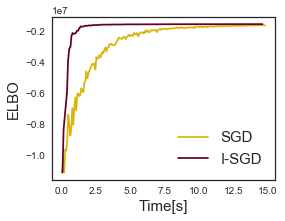

In [48]:
N = 50000
D = 500
batch_size = 1000
epochs = 9
samples = 1
learning_rate = 0.05
seed = 111
npr.seed(seed)    
data = 5 * npr.randn(N*D).reshape([N,D]) + 2
    
N = data.shape[0]
D = data.shape[1]
model = Normal(data)

npr.seed(seed)    
params = {}
params['means'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
params['log_sigmas'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
inference = Inference(model, params)
inference.run(4, batch_size, samples, learning_rate, 'SGD')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[1], label = 'SGD')


npr.seed(seed)    
params = {}
params['means'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
params['log_sigmas'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
inference = Inference(model, params)
inference.run(37, batch_size, samples, learning_rate, 'iSGD')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[0], label = 'I-SGD')

fig = plt.gcf()
fig.set_size_inches(4,3)
plt.ylabel('ELBO', fontsize = 15)
plt.xlabel('Time[s]', fontsize = 15)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend(loc = 4, fontsize = 15)
plt.savefig('/home/sakaya/MUPI/papers/uai17importance/normal.png', dpi=300, bbox_inches= 'tight')


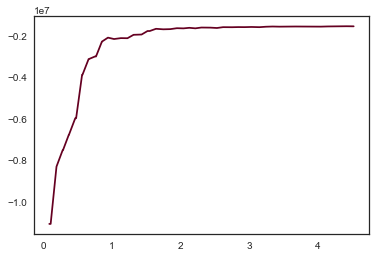

In [35]:
N = 50000
D = 500
batch_size = 1000
epochs = 10
samples = 1
learning_rate = 0.05
seed = 111
npr.seed(seed)    
data = 5 * npr.randn(N*D).reshape([N,D]) + 2
    
N = data.shape[0]
D = data.shape[1]
model = Normal(data)

npr.seed(seed)    
params = {}
params['means'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
params['log_sigmas'] = {'mu': npr.randn(D), 'tau': npr.randn(D)}
inference = Inference(model, params)
inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[0], label = 'I-SGD')


In [25]:
inference.params['means']['mu']

array([ 1.77573838,  1.96268406,  1.95584577,  1.93972951,  1.61430929,
        1.79043246,  1.97351441,  1.83855856,  1.55393325,  1.40305126,
        1.97324344,  1.41430456,  1.95608658,  2.03387453,  1.58305783,
        0.58744522,  1.8488054 ,  1.87162954,  1.97476188,  1.93518049,
        1.97815681,  1.95642314,  1.52081966,  0.89757739,  1.94648111,
        2.03176429,  0.40495311,  1.9371277 ,  2.09602829,  1.75674257,
        1.87761593,  1.8414587 ,  1.49466245,  1.07957009,  1.91477606,
        1.974513  ,  1.9346966 ,  2.14159745,  1.59022576,  2.02726572,
        1.2841781 ,  1.93756997,  1.99779624,  1.96238755,  2.09014089,
        1.81227384,  1.92640271,  1.4117972 ,  1.92764657,  1.97420127,
        1.97890961,  1.88535793,  1.91051899,  1.92327577,  1.87193054,
        2.04599566,  1.94600998,  2.01352141,  1.97328993,  1.8271023 ,
        1.60176396,  0.05915411,  1.91288947,  1.92263039,  2.08566917,
        1.77044354,  1.85590406,  2.00356436,  1.67149358,  2.05